# Graient Descent 최적화 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 손실 함수 정의 (Analytic)

In [2]:
def f(x):
  return 0.1*x**4 - 1.5*x**3 + 0.6*x**2 + 1.0*x + 20.0

## 손실 함수 미분 정의

In [3]:
def df_dx(x):
  return 0.4*x**3 - 4.5*x**2 + 1.2*x +1.0

## 하이퍼파라미터 정의

In [4]:
x = 5
eps = 1e-5
lr = 0.01
max_iter = 1000

## Gradient Descent 알고리즘 구현

In [5]:
min_x = x
min_y = f(min_x)

for _ in range(max_iter):
  grad = df_dx(x)
  new_x = x - lr * grad
  y = f(new_x)

  if min_y > y :
    min_x = new_x
    min_y = y

  if np.abs(x - new_x) < eps:
    break

  x = new_x

In [6]:
print(min_x, min_y)

10.955323272631201 -428.84677390087836


## Visualization

In [7]:
def gradient_descent(initial_x, learning_rate=0.01, eps=1e-5, max_iter=1000):
  x = initial_x

  x_log = [x]

  min_x = x
  min_y = f(min_x)

  for _ in range(max_iter):
    grad = df_dx(x)
    new_x = x - learning_rate * grad
    y = f(new_x)

    x_log.append(new_x)

    if min_y > y :
      min_x = new_x
      min_y = y

    if np.abs(x - new_x) < eps:
      break

    x = new_x

  return min_x, min_y, x_log

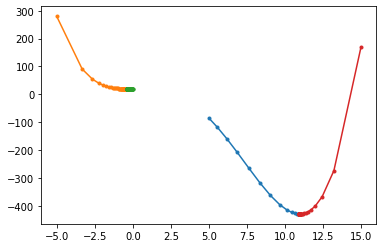

In [8]:
min_x1, min_y1, x_log1 = gradient_descent(initial_x=5)
min_x2, min_y2, x_log2 = gradient_descent(initial_x=-5)
min_x3, min_y3, x_log3 = gradient_descent(initial_x=0)
min_x4, min_y4, x_log4 = gradient_descent(initial_x=15, learning_rate=0.005)

y_log1 = f(np.array(x_log1))
y_log2 = f(np.array(x_log2))
y_log3 = f(np.array(x_log3))
y_log4 = f(np.array(x_log4))

plt.plot(x_log1, y_log1, '.-')
plt.plot(x_log2, y_log2, '.-')
plt.plot(x_log3, y_log3, '.-')
plt.plot(x_log4, y_log4, '.-')
plt.show()

# 수치 미분을 이용한 심층 신경망 학습

In [9]:
import time

## 유틸리티 함수

In [10]:
epsilon = 0.0001

def _t(x):
  return np.transpose(x)

def _m(A, B):
  return np.matmul(A, B)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def mean_squared_error(h, y):
  return 1 / 2 * np.mean(np.square(h - y))

## 뉴런 구현

In [11]:
from numpy.core.numeric import zeros_like
class Dense:
  def __init__(self, W, b, a):
    self.W = W
    self.b = b
    self.a = a

    self.dW = np.zeros_like(self.W)
    self.db = np.zeros_like(self.b)

  def __call__(self, x):
    return self.a(_m(_t(self.W), x) + self.b)

## 심층신경망 구현

In [15]:
class DNN:
  def __init__(self, hidden_depth, num_neuron, num_input, num_output, activation=sigmoid):
    def init_var(i, o):
      return np.random.normal(0.0, 0.01, (i, o)), np.zeros((o,))

    self.sequence = list()
    # First hidden layer
    W, b = init_var(num_input, num_neuron)
    self.sequence.append(Dense(W, b, activation))

    # Hidden layers
    for _ in range(hidden_depth-1):
      W, b = init_var(num_neuron, num_neuron)
      self.sequence.append(Dense(W, b, activation))

    # Output layer
    W, b = init_var(num_neuron, num_output)
    self.sequence.append(Dense(W, b, activation))

  def __call__(self, x):
    for layer in self.sequence:
      x = layer(x)
    return x

  def calc_gradient(self, x, y, loss_func):
    def get_new_sequence(layer_index, new_layer):
      new_sequence = list()
      for i, layer in enumerate(self.sequence):
        if i == layer_index:
          new_sequence.append(new_layer)
        else:
          new_sequence.append(layer)
      return new_sequence

    def eval_sequence(x, sequence):
      for layer in sequence:
        x = layer(x)
      return x

    loss = loss_func(self(x), y)

    for layer_id, layer in enumerate(self.sequence):
      for w_i, w in enumerate(layer.W):
        for w_j, ww in enumerate(w):
          W = np.copy(layer.W)
          W[w_i][w_j] = ww + epsilon

          new_layer = Dense(W, layer.b, layer.a)
          new_seq = get_new_sequence(layer_id, new_layer)
          h = eval_sequence(x, new_seq)

          num_grad = (loss_func(h, y) - loss) / epsilon # (f(x+eps) - f(x)) / eps
          layer.dW[w_i][w_j] = num_grad

      for b_i, bb in enumerate(layer.b):
          b = np.copy(layer.b)
          b[b_i] = bb + epsilon

          new_layer = Dense(layer.W, b, layer.a)
          new_seq = get_new_sequence(layer_id, new_layer)
          h = eval_sequence(x, new_seq)

          num_grad = (loss_func(h, y) - loss) / epsilon # (f(x+eps) - f(x)) / eps
          layer.db[b_i] = num_grad

    return loss

## 경사하강 학습법

In [16]:
def gradient_descent(network, x, y, loss_obj, alpha=0.01):
  loss = network.calc_gradient(x, y, loss_obj)
  for layer in network.sequence:
    layer.W += -alpha * layer.dW
    layer.b += -alpha * layer.db
  return loss

## 동작 테스트

In [18]:
x = np.random.normal(0.0, 1.0, (10,))
y = np.random.normal(0.0, 1.0, (2,))

dnn = DNN(hidden_depth=10, num_neuron=32, num_input=10, num_output=2, activation=sigmoid)

t = time.time()

for epoch in range(100):
  loss = gradient_descent(dnn, x, y, mean_squared_error, 0.01)
  print(f'Epoch {epoch}: Test loss {loss}')
print(f'{time.time() - t} seconds elapsed')

Epoch 0: Test loss 0.8909169577281527
Epoch 1: Test loss 0.8859158064490396
Epoch 2: Test loss 0.8809428785938215
Epoch 3: Test loss 0.8759990911317044
Epoch 4: Test loss 0.871085327538994
Epoch 5: Test loss 0.8662024372498569
Epoch 6: Test loss 0.8613512351940795
Epoch 7: Test loss 0.8565325014227139
Epoch 8: Test loss 0.8517469808190279
Epoch 9: Test loss 0.8469953828933816
Epoch 10: Test loss 0.8422783816602645
Epoch 11: Test loss 0.8375966155953063
Epoch 12: Test loss 0.8329506876690087
Epoch 13: Test loss 0.8283411654553323
Epoch 14: Test loss 0.8237685813111957
Epoch 15: Test loss 0.8192334326247535
Epoch 16: Test loss 0.8147361821276795
Epoch 17: Test loss 0.8102772582697204
Epoch 18: Test loss 0.8058570556501715
Epoch 19: Test loss 0.8014759355041439
Epoch 20: Test loss 0.7971342262386161
Epoch 21: Test loss 0.7928322240153858
Epoch 22: Test loss 0.7885701933766247
Epoch 23: Test loss 0.7843483679099246
Epoch 24: Test loss 0.7801669509481637
Epoch 25: Test loss 0.77602611630155